# MSigDb group tests

In this notebook, we use the group-based DISCOVER test to detect mutual exclusivity in predefined gene sets. These gene sets are extracted from the canonical pathway database of MSigDb.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [4]:
import discover

In [5]:
import nbsupport.io
import nbsupport.plots

In [6]:
from nbsupport.stats import fdr

## Genomic data

In [7]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [8]:
events = nbsupport.io.load_discover_matrix(dataFile, "/models/combined")

In [9]:
genes = numpy.char.partition(events.rownames.astype(str), "_")[:, 0]

## Gene sets

In [10]:
def readGmt(filename):
    with open(filename) as stream:
        return { line[0] : line[2:] for line in map(str.split, stream) }

In [11]:
def filterGeneSets(geneSets, genes):
    return {
        name : numpy.intersect1d(genes, geneSet)
        for name, geneSet
        in geneSets.iteritems()
        if len(numpy.intersect1d(genes, geneSet)) > 2 }

In [12]:
pathwayGeneSets = readGmt("../data/msigdb/c2.cp.v5.0.symbols.gmt")

In [13]:
pathwayGeneSets = filterGeneSets(pathwayGeneSets, genes)

In [14]:
selectedPathways = {
    name : genes
    for name, genes
    in pathwayGeneSets.iteritems()
    if name.startswith("ST_") or name.startswith("SA_")}

## Gene set analysis

In [15]:
pValues = numpy.array([
        discover.groupwise_discover_test(events[numpy.in1d(genes, pathwayGenes)], "impurity")
        for pathwayGenes in selectedPathways.itervalues()])

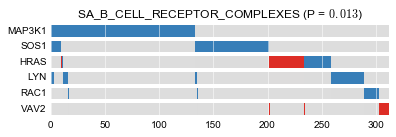

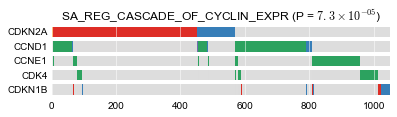

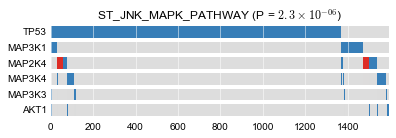

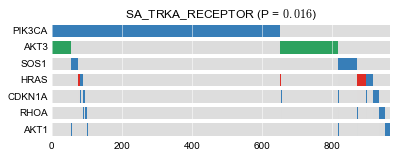

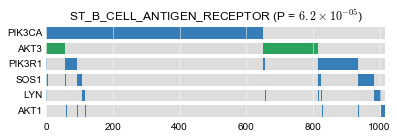

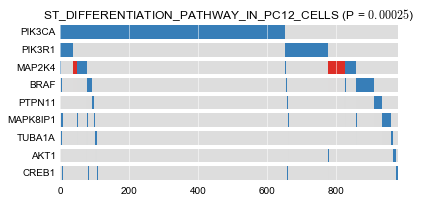

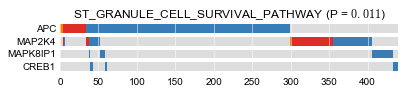

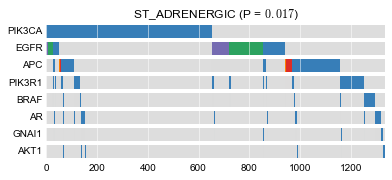

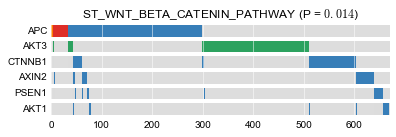

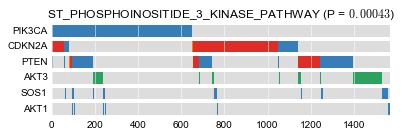

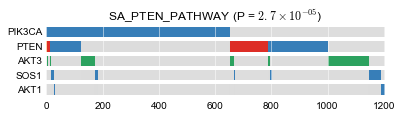

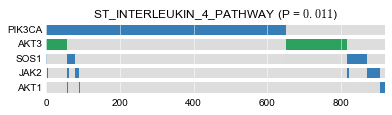

In [16]:
with matplotlib.rc_context({"font.family": "Arial"}):
    for p, q, (name, geneSet) in zip(pValues, fdr(pValues), selectedPathways.iteritems()):
        if q < 0.05:
            x = events[numpy.in1d(genes, geneSet)]
            nbsupport.plots.event_plot(x)
            p_formatted = ("%.2g" % p).replace("e", "\\times 10^{") + "}"
            plt.title("%s (P = $%s$)" % (name, p_formatted))
            plt.show()